In [1]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import KFold
import scipy
from arch import arch_model

data = pd.read_csv("data.csv", index_col=0)
log_r = np.log(data/data.shift(1))

## Q1 - Data exploration

#### 1 - Missing data

Visualisation of missing data in the dataset show that:
* C, E and G require price interpolation 
* All data require price extrapolation at end of dataset 

Text(0.5, 1.0, 'Visualisation of missing data')

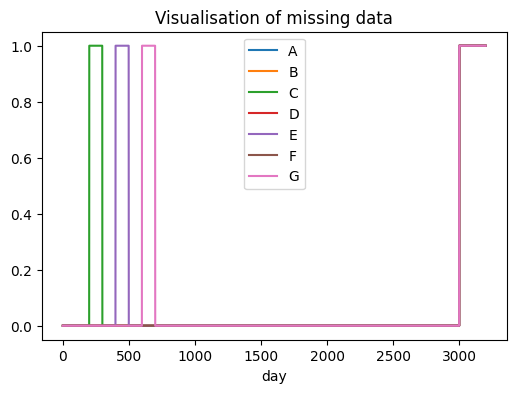

In [2]:
missing_data = (data.isnull().astype(int))
fig, axes = plt.subplots(figsize=(6, 4))
missing_data.plot(ax=axes)
axes.set_title("Visualisation of missing data")

### 2 - Basic financial statistics

Looking at some high level statistics, I notice:
* Large dispersion of realised vol
* Some underlyings seem to capture a premia (F, A) while others closer to random walk (D, E) 

In [4]:
def performance_metrics(df):
    def _sr(w):
        log_r = np.log(df.div(df.shift(w))).mean()
        vol = np.log(df.div(df.shift(w))).std()
        sr = log_r/vol * np.sqrt(252/w)
        return sr

    def _annualised_ret():
        T = (df.index[-1] - df.index[0])/365.25
        r = (df.iloc[-1] / df.iloc[0])**(1/T)-1
        return r

    def _calmar_ratio(w):
        log_r = np.log(df.div(df.shift(w)))
        cond_vol = log_r[log_r<=0].std()
        calmar = log_r.mean() / cond_vol * np.sqrt(252 / w)
        return calmar

    def _cvar(w, q):
        r= df.pct_change(w)
        q = r.quantile(q)
        cvar = r[r <= q].mean()
        return cvar

    def _max_dd_over_w(w):
        return df.pct_change(w).min()

    def __max_dd_over_hist(s):
        mdd = 0
        peak = s.iloc[0]
        for x in s:
            if x > peak:
                peak = x
            dd = (peak - x) / peak
            if dd > mdd:
                mdd = dd
        return -mdd

    def _max_dd_over_hist():
        return pd.Series({u: __max_dd_over_hist(df[u]) for u in df.columns})

    metrics = {"Annualised Ret":_annualised_ret(),
               "Realised Vol": np.log(df.div(df.shift(1))).std()*np.sqrt(252),
               "Sharpe Ratio (daily)": _sr(w=1),
               "Sharpe Ratio (monthly)": _sr(w=20),
               "Calmar Ratio":_calmar_ratio(w=20),
               "Max DD over 1W": _max_dd_over_w(w=5),
               "Max DD (peak to trough)": _max_dd_over_hist(),
               "C-VaR(5%, 1M)": _cvar(w=20, q=0.05),
    }
    metrics = pd.DataFrame(metrics).T.round(2)
    return metrics
performance_metrics(data.dropna())

,A,B,C,D,E,F,G
Annualised Ret,0.04,0.22,0.22,0.08,-0.03,0.06,0.25
Realised Vol,0.08,0.58,0.57,0.36,1.07,0.07,0.54
Sharpe Ratio (daily),0.42,0.26,0.27,0.16,-0.02,0.61,0.31
Sharpe Ratio (monthly),0.46,0.29,0.26,0.14,-0.02,0.71,0.35
Calmar Ratio,0.80,0.34,0.34,0.19,-0.03,1.23,0.67
Max DD over 1W,-0.04,-0.58,-0.49,-0.36,-0.76,-0.05,-0.24
Max DD (peak to trough),-0.15,-0.97,-0.89,-0.88,-1.00,-0.13,-0.85
"C-VaR(5%, 1M)",-0.04,-0.30,-0.31,-0.21,-0.39,-0.04,-0.21


### 3 - Dependencies in the time-series

**Takeaway**: 
* A handful of tickers exhibit significant dependency, ex: (B,C), (E, G), (A, F), (C, G) 
* Significant betas/correlations tend to be positive
* These dependencies could be leveraged when reconstructing missing data
  
#### a) Correlation

Running in-sample correlation/regression analysis uncovers some relationship in the data: 
* Few pairs show robust positive correlation throughout the period: (A, F), (B, C)
* Evidence of unstable correlation (sign flips): eg. (B, F)

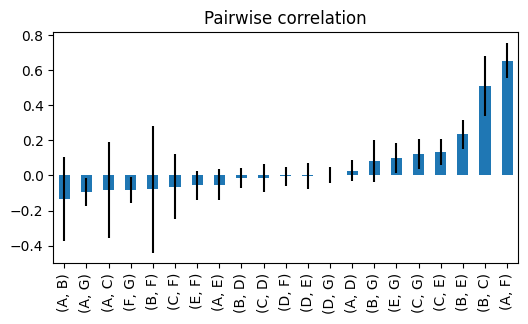

In [5]:
def estimate_rolling_corr(halflife=120): 
    rolling_corr = log_r.ewm(halflife).corr()
    R = {t: rolling_corr.xs(t) for t in log_r.index}
    # reduce corr matrices to upper triangular
    R = {t: r*np.triu(np.ones(r.shape[-2:]), k=1).astype(np.bool) for t, r in R.items()}
    R = pd.concat(R, keys=R).replace({0:np.nan}).stack()
    
    unique_pairs = set([x[1:] for x in list(R.index)])
    
    pairwise_corr = pd.DataFrame({p: R.xs(p, level=[1,2]) for p in unique_pairs}).loc[50:]
    median_corr = pairwise_corr.median().sort_values()
    return pairwise_corr, median_corr

def plot_correlation():
    pairwise_corr, median_corr = estimate_rolling_corr()
    fig, axes = plt.subplots(figsize=(6, 3))
    axes.set_title("Pairwise correlation")
    yerr = pairwise_corr.std().loc[median_corr.index]
    median_corr.plot.bar(ax=axes, yerr=yerr)

plot_correlation()

#### b) Regression 

Let's investigate a bit more robustly the above relationships. 

Let $J$ be the set of tickers contained in the dataset. For a given ticker $j \in J$, let us consider the linear model: 

$y_{j}=X{_{\bar{j}}}\beta_{j} + \varepsilon$

where $y_{j}$ is the vector of daily log-returns of asset $j$ and $X{_{\bar{j}}}$ is the matrix of standardised daily log-returns of tickers $J\setminus{\set{j}}$

For each ticker, confidence intervals for $\hat{\beta}_{j}^{OLS}$ are built by bootstrapping (500 replications). 


Text(0.5, 1.0, '$\\hat{\\beta}^{OLS}$ significant with risk $\\alpha=5$%')

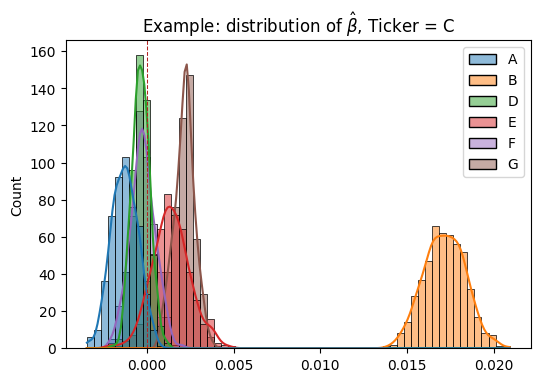

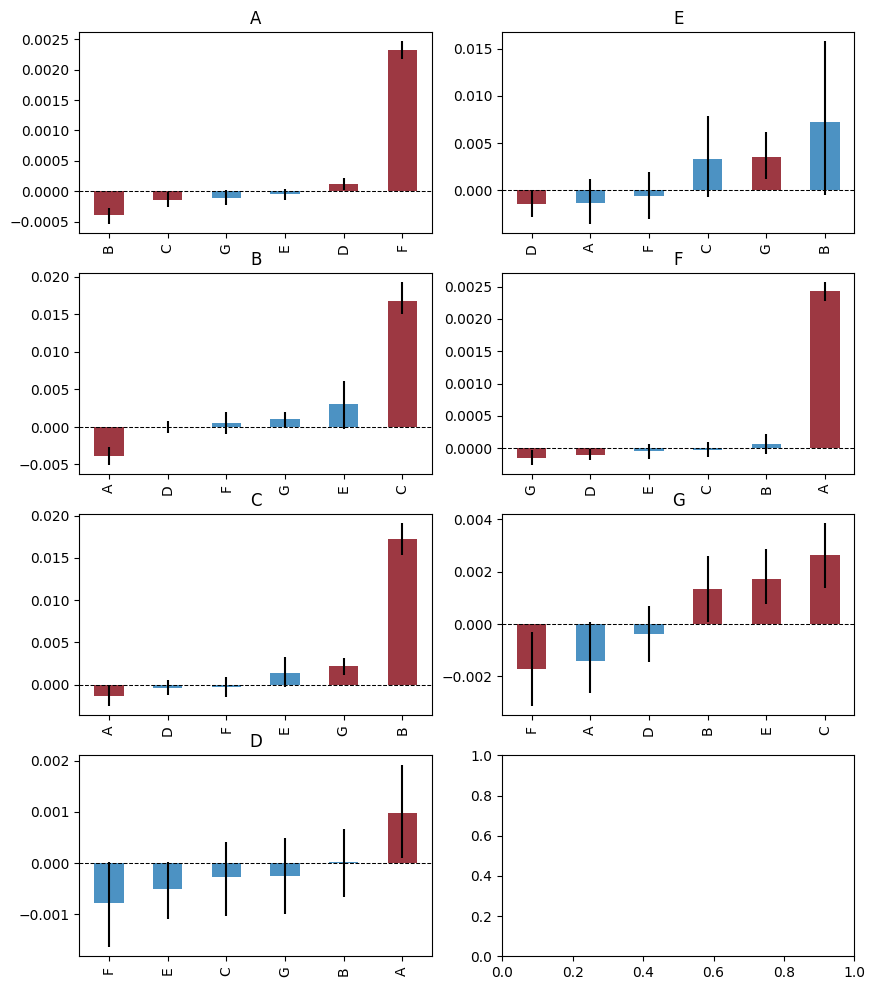

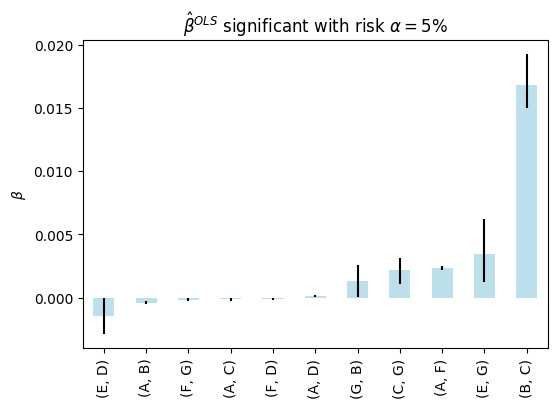

In [6]:
def _preprocess(target): 
    features = [l for l in obs_data.columns if l!=target] 
    X = (obs_data[features]-obs_data[features].mean())/obs_data[features].std()
    y = obs_data[target] # / obs_data[target].std()
    return y, X
    
def _bootstrap_betas(y, X, B=500): 
    idx = X.index
    r_sq, betas = {}, {}
    for b in range(B):
        resample = np.random.choice(idx, size=len(idx), replace=True)
        X_res, y_res = X.loc[resample], y.loc[resample]
        reg = LinearRegression().fit(X_res, y_res)
        r_sq[b]=reg.score(X_res, y_res)
        betas[b]=reg.coef_
    betas = pd.DataFrame(betas, index=X.columns).T
    r_sq = pd.Series(r_sq)
    return betas, r_sq

def _beta_confidence(betas, alpha=0.05): 
    CI = dict(zip(betas.columns, zip(np.median(betas, axis=0), np.quantile(betas, q=alpha, axis=0), np.quantile(betas, q=1-alpha, axis=0))))
    CI = pd.DataFrame(CI, index=("Beta", "LowerBound", "UpperBound"))
    return CI

def _run_regression(target): 
    y, X = _preprocess(target)
    betas, r_sq = _bootstrap_betas(y, X)
    CI = _beta_confidence(betas)
    return dict(betas=betas, CI=CI, r_sq=r_sq)

def _plot_example(target): 
    fig, axes = plt.subplots(figsize=(6, 4))
    sns.histplot(data=results.get(target).get("betas"), ax=axes, kde=True)
    axes.set_title(r"Example: distribution of $\hat{\beta}$, " + f"Ticker = {target}")
    axes.axvline(0, linestyle="--", color="firebrick", linewidth=0.75)
    
def _plot_betas(results): 
    fig, axes = plt.subplots(4,2, figsize=(10, 12))
    i, j = 0, 0
    for target in results: 
        CI = results.get(target).get("CI")
        CI = CI.sort_values(by="Beta", axis=1)
        
        yerr=(CI.loc["Beta"]-CI.loc["LowerBound"], CI.loc["UpperBound"]-CI.loc["Beta"])
        CI.loc["Beta"].plot.bar(yerr=yerr, alpha=0.8, ax=axes[i][j])
    
        highlight = ((CI>0).sum(axis=0) ==0 ) | ((CI<0).sum(axis=0) ==0)
        significant = (CI[highlight[highlight].index]).reindex(CI.columns, axis=1)
        significant.loc["Beta"].plot.bar(ax=axes[i][j], color="firebrick", alpha=0.8)
    
        axes[i][j].axhline(0, linestyle="--", color="black", linewidth=0.75)
        axes[i][j].set_title(target)
        i+=1
        if i%4==0: 
            i=0
            j+=1
        if j%2==0: 
            j=0

def _filter_beta(target, results):
    CI = results.get(target).get("CI")
    CI = CI.sort_values(by="Beta", axis=1)
    
    highlight = ((CI>0).sum(axis=0) ==0 ) | ((CI<0).sum(axis=0) ==0)
    significant = (CI[highlight[highlight].index]) # .reindex(CI.columns, axis=1)
    return significant

def _aggregate_beta(results): 
    # filtered_betas = pd.concat([_filter_beta(target, results) for target in results], axis=1, keys=results).T
    # retain = tuple(set([tuple(sorted(x)) for x in filtered_betas.index])) # only keep unique pairs
    # filtered_betas = pd.concat([filtered_betas.xs(pair) for pair in retain], axis=1).T.sort_values(by="Beta")
    filtered_betas = pd.concat([_filter_beta(target, results) for target in results], axis=1, keys=results).T
    filtered_betas["Pair"] = [sorted(x) for x in filtered_betas.index]
    filtered_betas = filtered_betas[~filtered_betas.Pair.duplicated(keep="first")].sort_values(by="Beta")

    return filtered_betas

obs_data = log_r.dropna()
results = {target: _run_regression(target) for target in obs_data.columns}

_plot_example(target="C")
_plot_betas(results)

filtered_betas = _aggregate_beta(results)
yerr=(filtered_betas["Beta"]-filtered_betas["LowerBound"], filtered_betas["UpperBound"]-filtered_betas["Beta"])

fig, axes = plt.subplots(figsize=(6, 4))
filtered_betas["Beta"].plot.bar(color="lightblue", alpha=0.8, yerr=yerr, ax=axes)
axes.set_ylabel(r"$\beta$")
axes.set_title(r"$\hat{\beta}^{OLS}$ significant with risk $\alpha=5$%")

## Question 2 - Estimation of missing data

Missing prices in this dataset come in 2 flavours: 
* Patches of data missing within each time series (**interpolation problem**)
* End of time series missing (**extrapolation problem**)

In what follows I am assuming the data is missing **completely at random** - e.g. patches of data of size $N$ were deleted, but the fact that the data is missing does not contain any meaningul information about the data generating process

### 1 - Interpolation Problem

#### Method 1 - Imputation by regression

Let $J$ be the set of tickers contained in the dataset.

For a given ticker $j \in J$, let us consider the linear model: 

$y_{j}=X{_{\bar{j}}}\beta_{j} + \varepsilon$

where $y_{j}$ is the vector of daily log-returns of asset $j$ and $X{_{\bar{j}}}$ is the matrix of standardised daily log-returns of tickers $J\setminus{\set{j}}$

**Step 1: estimation of  $\hat{\beta}$**

* $\forall j \in J$, the dataset is split between $(X{_{\bar{j}}}^{obs}$, $y_{j}^{obs})$ and $X{_{\bar{j}}}^{missing}$ where prices for underlying $j$ are missing

* $\hat{\beta_j}$ estimated by 5-fold cross-validation, with tuning parameter (regularised models) optimising for MSE over the test set.

* Standard OLS or regularised models available ($\hat{\beta}_j=\hat{\beta}^{OLS}$, $\hat{\beta}_j=\hat{\beta}^{Ridge}$, $\hat{\beta}_j=\hat{\beta}^{Lasso}$)

**Step 2 : recovering the nodes**

The missing log-returns in the interval $t \in [0,T]$ are estimated by the linear model: 

$\hat{y}^{missing}_{j}=X^{obs}_{\bar{j}}\hat{\beta}_j$

The boundary conditions impose:

$\sum_{t=0}^{T}y_{t,j}^{missing}=log(P_{T}/P_{0})$

This implies a correction term (drift) over $T$: 

$\hat{\mu}_{0,T} = \sum_{t=0}^{T}\hat{y_{t,j}}^{missing}-log(P_{T}/P_{0})$

Assuming linear drift, the correction term is: 

$\hat{\mu}_{t}=\hat{\mu}_{0,T}/T$

Finally: 

$\hat{y}^{corrected}_{j}$ = $\hat{y}^{missing}_{j} + \hat{\mu}_{t}$


**Step 3: building a confidence interval**

$\forall t \in [0,T]$, the daily residuals are assumed to be **Gaussian** and **iid**,  $\varepsilon_t \sim N(0, \sigma^{2}_{\varepsilon})$
* $\hat{\sigma_\varepsilon}$ is estimated by fitting a Gaussian density to the predicted residuals $\varepsilon_{j} =y_{j}^{obs} - \hat{y}_{j}^{pred}$ of each fold of the cross-validation
* Gaussian and i.i.d assumptions of residuals are sense-checked with a visual inspection of ACF plot and kernel density estimation

When the data is missing over $T$ consecutive days, the error terms propagate as a function of square root of time, with the maximum uncertainty corresponding to the mid-point $\lfloor T/2 \rfloor$ of the missing set:

$\varepsilon_{0,\tau}=\sum_{t=0}^{\tau}\varepsilon_t \sim N(0, \tau \sigma^2)$

with $0\leq \tau \leq \lfloor T/2 \rfloor$

Therefore the confidence interval of the log return with risk $\alpha$ at time $0\leq \tau \leq \lfloor T/2 \rfloor$ is: 

$(\hat{y}_{t}^{corrected} - z^{1-\alpha} \hat{\sigma}_{\varepsilon}) \sqrt(\tau), \hat{y}_{t}^{corrected}  + z^{1-\alpha} \hat{\sigma}_{\varepsilon}) \sqrt(\tau))$

**Takeaways and discussion**: 
* Lasso regression achieves a cross validation score comparable to other models while being more parsimonious - it is therefore the preferred model 
* When regressing over the training set (observed values), ticker C has significant positive cross-validation score ($r^2\approx$25%), while all models perform poorly for tickers E and G. One expects therefore noisy predictions for those two tickers.
* The confidence intervals are built accounting for the uncertainty of the residuals. Given the relatively low cross validation $r^2$ of these models (around 25% for stock C, close to 0% for stocks E & G), one can expect residuals to be a primary contributor to noise indeed.

However, other sources of noise not accounted for in this model are:
* uncertainty coming from the **estimation of $\hat{\beta}_j$** (a Bayesian approach would consider the distribution of $\beta_j$ instead of using fixed point estimates)
* uncertainty of the **underlying drift process $\hat{\mu}_{t}$** which is assumed linear and deterministic in this approach. There are infinitly many ways of connecting the nodes $P_0$ and $P_T$ - likely trajectories could be modeled using a Gaussian process with the choice of kernel function driving the smoothness of the path (squared exponential, matern..)

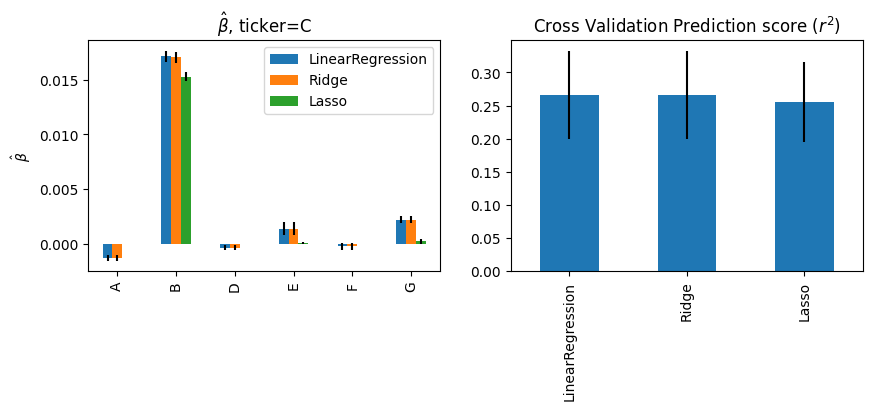

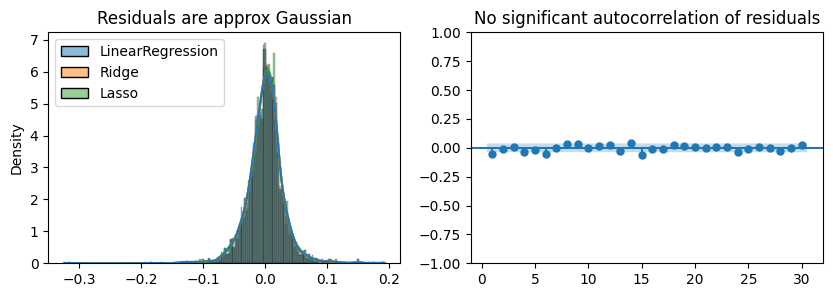

In [7]:
class LinRegression(object):
    def __init__(self):
        pass

    def _load(self):
        data = pd.read_csv("data.csv", index_col=0)
        self.log_r = np.log(data / data.shift(1))
        self.data = data

    def _split_train_test_data(self, target, t0, t1):
        features = [c for c in self.data.columns if c != target]
        
        test = self.log_r.loc[t0:t1]
        train = self.log_r.loc[[t for t in self.log_r.index if t not in test.index]]
        train = train[train.isna().sum(axis=1) == 0] # only keep full dataset available for training

        self.X_train = (train[features] - train[features].mean()) / train[features].std()
        self.y_train = train[target]
        self.X_test =  (test[features] - test[features].mean()) / test[features].std()
        self.features = features
        self.test_idx = test.index
    
    def _get_model(self, model_name, k):
        # For Lasso / Ridge, tune alpha by cross validation
        if model_name == "Lasso":
            reg = LassoCV(cv=k).fit(self.X_train, self.y_train)
            alpha = reg.alpha_
            self.model = Lasso(alpha=alpha)

        elif model_name == "Ridge":
            reg = RidgeCV(cv=k).fit(self.X_train, self.y_train)
            alpha = reg.alpha_
            self.model = Ridge(alpha=alpha)

        elif model_name == "LinearRegression":
            self.model = LinearRegression()

        else: raise Exception(f"{model_name} is invalid")

    def _fit(self):
        self.model.fit(self.X_train, self.y_train)
        
    def _predict(self):
        self.y_pred = pd.Series(self.model.predict(self.X_test), index=self.test_idx)

    def _cv_score_and_residuals(self, k):
        # Explicitly define KFold cross-validation
        kf = KFold(n_splits=k, shuffle=True, random_state=10)
        
        beta, score, residuals_pred = {}, {}, {}
        k = 0
        for train_index, test_index in kf.split(self.X_train):
            # Split data into training and test sets for this fold
            X_train_cv, X_test_cv = self.X_train.iloc[train_index], self.X_train.iloc[test_index]
            y_train_cv, y_test_cv = self.y_train.iloc[train_index], self.y_train.iloc[test_index]
        
            # Fit the model on the training data
            self.model.fit(X_train_cv, y_train_cv)
        
            # Store the coefficients and intercept
            beta[k] = self.model.coef_
            
            # Predict on the test data
            y_pred = self.model.predict(X_test_cv)
            score[k] = self.model.score(X_test_cv, y_test_cv)
            
            # # Calculate residuals for this fold
            residuals = y_test_cv - y_pred
        
            # # Append the residuals to the list
            residuals_pred[k] = residuals
            k+=1
            
        self.beta_cv = pd.DataFrame(beta, index=self.features)
        self.residuals_cv = pd.concat(list(residuals_pred.values()))
        self.score_cv = pd.Series(score)

    def _fit_residuals(self): 
        self.mu_residuals, self.std_residuals = scipy.stats.norm.fit(self.residuals_cv)
    
    def __call__(self, target, t0, t1, model, k=5):
        self._load()
        self._split_train_test_data(target, t0, t1)
        self._get_model(model, k)
        self._fit()
        self._predict()
        self._cv_score_and_residuals(k)
        self._fit_residuals()

        res = dict(y_pred=self.y_pred, 
                   beta=pd.Series(self.model.coef_, index=self.features), 
                   score=self.model.score(self.X_train, self.y_train), 
                   beta_cv = self.beta_cv, 
                   residuals_cv=self.residuals_cv, 
                   score_cv=self.score_cv, 
                   mu_residuals=self.mu_residuals, 
                   std_residuals=self.std_residuals,
                  )
        return res

def model_comparison(ticker="C", t0=199, t1=305):

    models = ["LinearRegression", "Ridge", "Lasso"]
    res = {model: LinRegression()(ticker, t0=t0, t1=t1, model=model, k=5) for model in models}

    betas = pd.DataFrame({model: res[model].get("beta_cv").mean(axis=1) for model in models})
    yerr= pd.DataFrame({model: res[model].get("beta_cv").std(axis=1) for model in models})
    
    fig, axes = plt.subplots(1,2, figsize=(10, 3))
    betas.plot.bar(ax=axes[0], yerr=yerr)
    axes[0].set_title(r"$\hat{\beta}$" + f", ticker={ticker}")
    axes[0].set_ylabel(r"$\hat{\beta}$")
                      
    score = pd.Series({model: res[model].get("score_cv").mean() for model in models})
    yerr= pd.Series({model: res[model].get("score_cv").std() for model in models})
    
    score.plot.bar(ax=axes[1], yerr=yerr)
    axes[1].set_title("Cross Validation Prediction score $(r^2)$")

def residual_check(ticker="C", t0=199, t1=305):
    models = ["LinearRegression", "Ridge", "Lasso"]
    res = {model: LinRegression()(ticker, t0=t0, t1=t1, model=model, k=5) for model in models}
    
    fig, axes = plt.subplots(1,2, figsize=(10, 3))
    residuals = pd.DataFrame({model: res.get(model).get("residuals_cv") for model in models})
    sns.histplot(data=residuals, kde=True, ax=axes[0], stat="density")
    axes[0].set_title("Residuals are approx Gaussian")
    mean, std_dev = scipy.stats.norm.fit(res.get("LinearRegression").get("residuals_cv"))

    xmin, xmax = residuals.min(), residuals.max()
    x = np.linspace(xmin, xmax, 100)
    
    p = scipy.stats.norm.pdf(x, mean, std_dev)
    # axes[0].plot(x, p, 'k', linewidth=1, label='Fitted Gaussian')

    sm.graphics.tsa.plot_acf(residuals["LinearRegression"], title="No significant autocorrelation of residuals", zero=False, lags=30, ax=axes[1])
    
# res = LinRegression()("C", t0=199, t1=305, model="LinearRegression", k=5)

model_comparison(ticker="C", t0=199, t1=305)
residual_check(ticker="C", t0=199, t1=305)

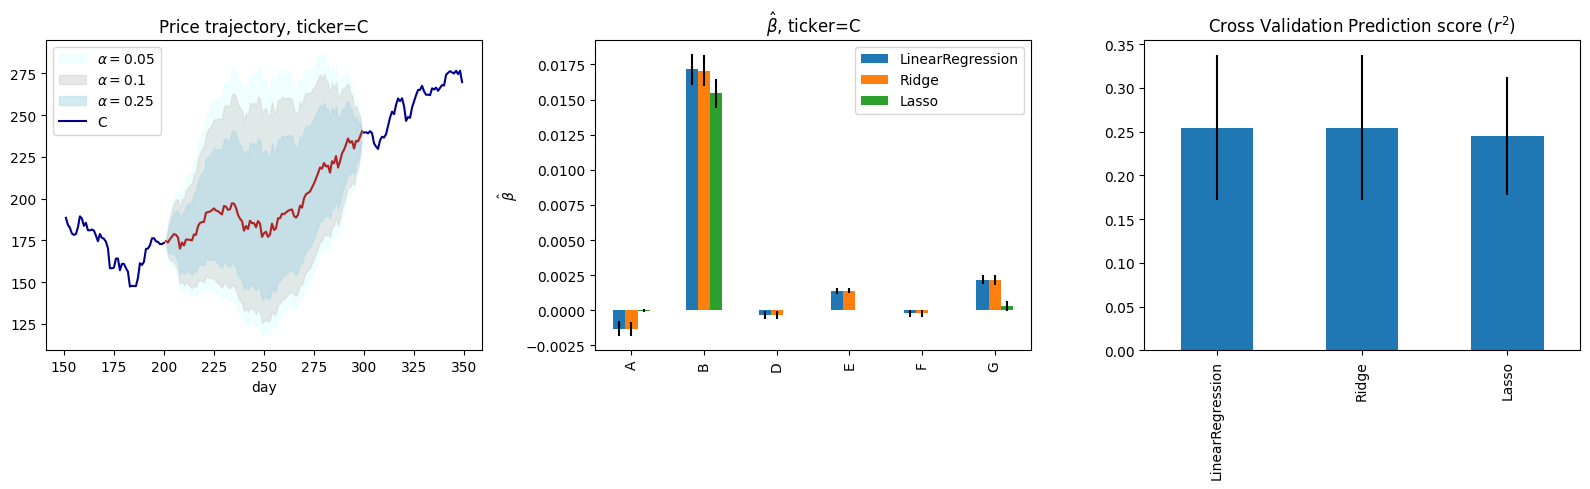

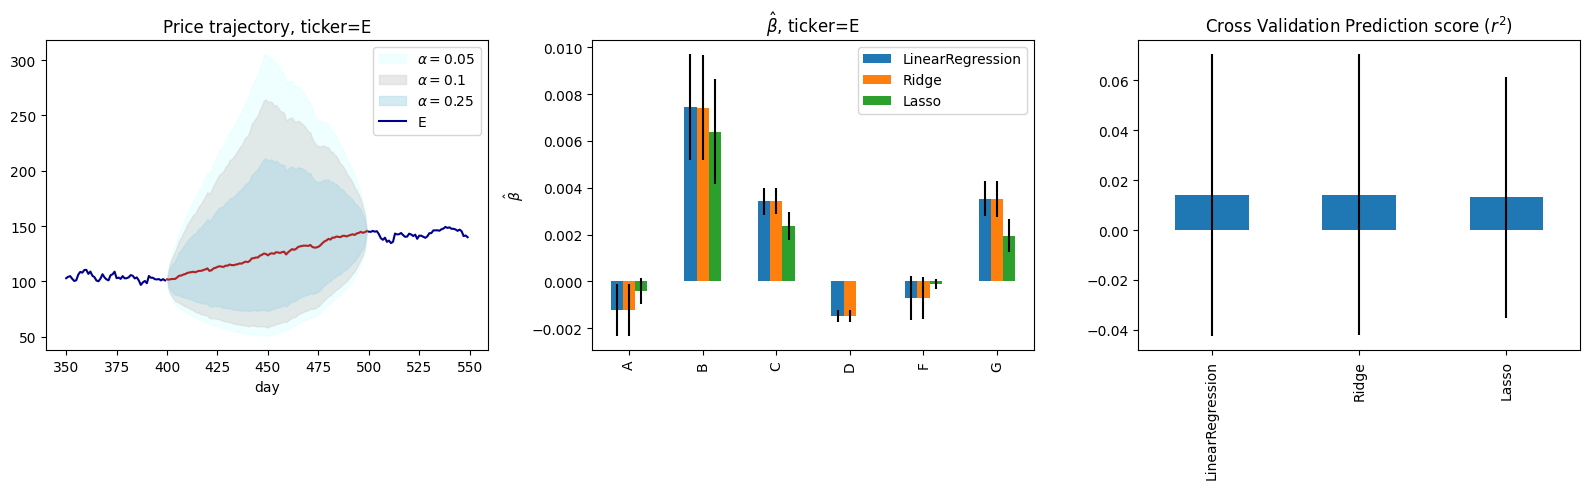

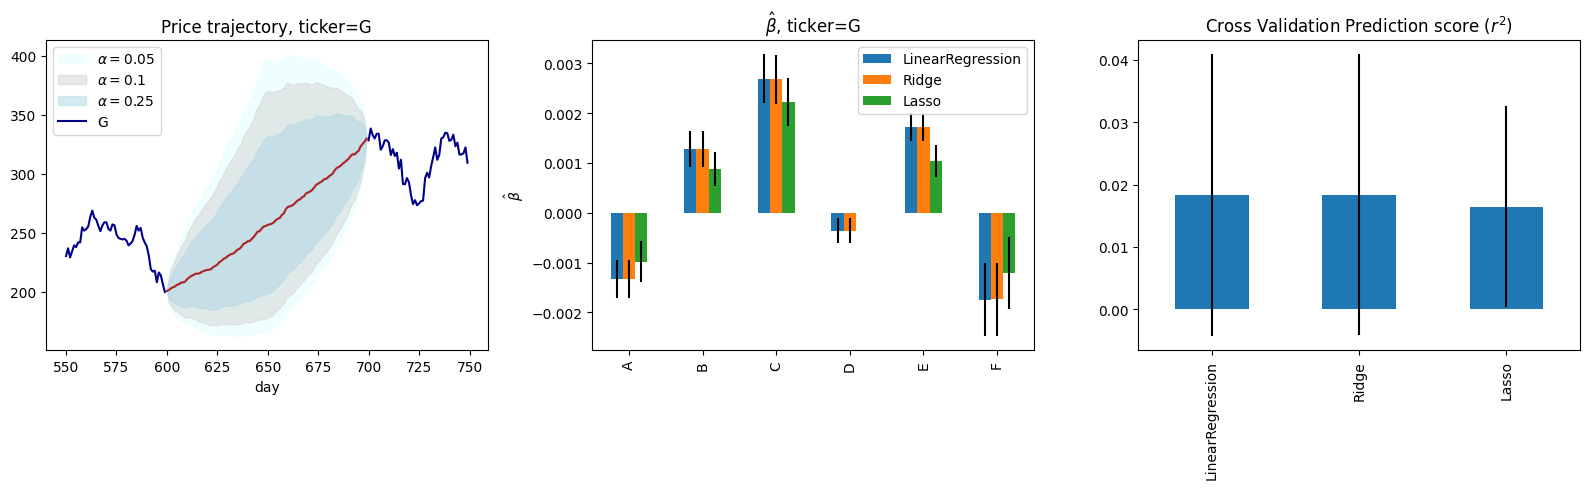

In [8]:
class PriceImputationRegression(object): 
    def __init__(self): 
        pass

    # def _load(self):
    #     data = pd.read_csv("data.csv", index_col=0)
    #     self.log_r = np.log(data / data.shift(1))
    #     self.data = data
        
    def _predict_price(self): 
        # correcting price obtained by regression by drift needed to connect the nodes
        y_pred = self.regression.get("y_pred")
        correction = (np.log(self.p1/self.p0)-y_pred.sum())/(self.t1-self.t0)
        self.y = y_pred + correction
        self.price_pred = self.p0*np.exp(self.y.cumsum())

    def _confidence_interval(self, alpha):
        sigma = self.regression.get("std_residuals")
        z = scipy.stats.norm.ppf((1-alpha/2))
        
        idx = self.y.index
        t_start = idx[0]
        t_end = idx[-1]
        T = np.median(idx)
        upper_bound = pd.Series({t: z * sigma * np.sqrt(t-t_start) if t<=T else z * sigma * np.sqrt(t_end-t) for t in self.y.index })
        lower_bound = pd.Series({t: z * sigma * np.sqrt(t-t_start) if t<=T else z * sigma * np.sqrt(t_end-t) for t in self.y.index })
        
        lower_price = (self.p0*np.exp((self.y - lower_bound.diff().fillna(0)).cumsum()))
        upper_price = (self.p0*np.exp((self.y + upper_bound.diff().fillna(0)).cumsum()))
    
        return pd.DataFrame(dict(lower_price=lower_price, upper_price=upper_price))

    def _confidence_intervals(self, alphas): 
        ci = {}
        for alpha in alphas:
            ci[alpha] = self._confidence_interval(alpha)
        self.ci = ci

    def _plot(self, alphas, target): 
        fig, axes = plt.subplots(1,3, figsize=(16, 5))

        # plot price and confidence interval
        axes[0].plot(self.price_pred, color="firebrick")
        for alpha, ts in self.ci.items(): 
            axes[0].fill_between(ts.index, y1=ts.lower_price, y2=self.price_pred, alpha=0.5, color=alphas[alpha], label=r"$\alpha=$" + f"{alpha}")
            axes[0].fill_between(ts.index, y1=self.price_pred, y2=ts.upper_price, alpha=0.5, color=alphas[alpha])
        data.loc[self.t0-50:self.t1+50, target].plot(ax=axes[0], color="darkblue")
        axes[0].legend()
        axes[0].set_title(r"Price trajectory" + f", ticker={ticker}")
        
        # plot coefs estimated with various models
        models = ["LinearRegression", "Ridge", "Lasso"]
        res = {model: LinRegression()(target, t0=self.t0, t1=self.t1, model=model, k=5) for model in models}
    
        betas = pd.DataFrame({model: res[model].get("beta_cv").mean(axis=1) for model in models})
        yerr= pd.DataFrame({model: res[model].get("beta_cv").std(axis=1) for model in models})

        betas.plot.bar(ax=axes[1], yerr=yerr)
        axes[1].set_title(r"$\hat{\beta}$" + f", ticker={ticker}")
        axes[1].set_ylabel(r"$\hat{\beta}$")

        # plot x-validation score
        score = pd.Series({model: res[model].get("score_cv").mean() for model in models})
        yerr= pd.Series({model: res[model].get("score_cv").std() for model in models})
        
        score.plot.bar(ax=axes[2], yerr=yerr)
        axes[2].set_title("Cross Validation Prediction score $(r^2)$")

        plt.tight_layout()
    
    def __call__(self, target, t0, t1, model, alphas, k=5, plot=True): 
        self.regression = LinRegression()(target, t0, t1, model, k)
        self.p0, self.p1 = data.loc[t0-1, target], data.loc[t1+1, target]
        self.t0, self.t1 = t0, t1

        self._predict_price()
        self._confidence_intervals(alphas)
        if plot: self._plot(alphas, target)

def find_missing_prices_interp(data):
    def _find_missing_prices(ticker): 
        ts = getattr(data, ticker)
        missing_dates = ts[ts.isna()].index
        missing_set = []
        start=missing_dates[0]
        for t0, t1 in zip(missing_dates[:-1], missing_dates[1:]): 
            if t1 - t0 > 1: 
                end = t0
                missing_set += [(start, end)]
                start = t1
            # if t1 == missing_dates[-1]: 
            #     end=t1
            #     missing_set+=[(start, end)]  
        return missing_set
    return {ticker: _find_missing_prices(ticker) for ticker in data.columns}
        
alphas = {0.05: "lightcyan", 
          0.10: "lightgrey", 
          0.25: "lightblue", 
         }

missing_prices = find_missing_prices_interp(data)

for ticker, dates in missing_prices.items(): 
    for t0, t1 in dates:
        PriceImputationRegression()(target=ticker, t0=t0, t1=t1, model="Lasso", alphas=alphas)

#### Method 2 - Imputation by simulation

Let's assume the underlying dynamic is a GBM with $dS_t = \mu_{t}S_tdt + \sigma S_tdW_t$

* $\hat{\mu}_{t}$ can be set to a constant so the nodes are recovered (as per Method 1) or can be interpolated using points in the neighborhood of missing data (e.g. spline interpolation)
* $\hat{\sigma}$ is estimated using EWM realised volatility in the neighborhood of the missing data (e.g. halflife = 120d)

Confidence intervals for the missing prices are constructed by simulating a large number of trajectories and reporting the quantiles of the simulated set.

This imputation method gives results consistent with method 1 when the covariates are mostly noisy (trajectories E & G)

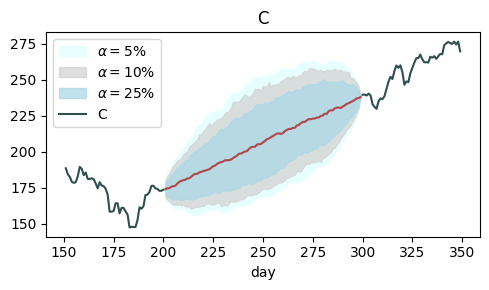

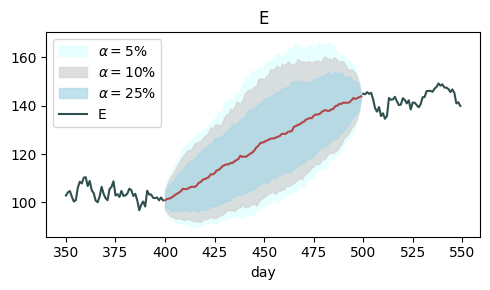

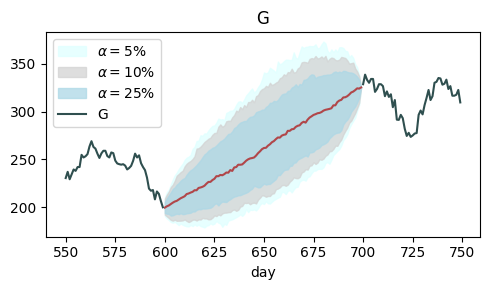

In [11]:
class PriceImputationSimulation(object):

    def __init__(self, settings):
        for key, val in settings.items():
            setattr(self, key, val)

    def _load(self):
        data = pd.read_csv("data.csv", index_col=0)
        self.log_r = np.log(data / data.shift(1))
        self.data = data

    def _estimate_mu(self, ticker, t0, t1):
        # restrict dataset to n_point_interp around boundary
        data_fit = self.data.loc[t0 - self.n_point_interp:t1 + self.n_point_interp, ticker]
        y_train = pd.concat([data_fit.loc[t0 - self.n_point_interp:t0 - 1], data_fit.loc[t1 + 1:t1 + self.n_point_interp]])
        X_train = np.array(y_train.index)
        X_test = np.array(data_fit.loc[t0:t1].index).reshape(-1, 1)
        spline = CubicSpline(X_train, y_train)
        self.S = pd.Series(spline(X_test).reshape(1, -1)[0])
        self.mu = np.log(self.S / self.S.shift(1)).fillna(0)

    def _estimate_sigma(self, ticker, t0, t1):
        self.sigma = self.log_r[ticker].ewm(halflife=self.w).std().iloc[t0 - self.w:t1 + self.w].mean()

    def _price_from_iid_returns(self, t0, t1):
        dW =  np.random.normal(size=t1 - t0 + 1)
        dW -= dW.mean()
        s = self.p0 * np.exp((self.mu + self.sigma * dW).cumsum())
        return s

    # def _price_from_corr_returns(self, t0, t1, ticker):
    #     tickers = [t for t in self.log_r.columns if t not in [ticker]]

    #     # observed prices
    #     X_obs = self.log_r.loc[t0:t1, tickers]
    #     N = len(X_obs)
    #     X_new = np.random.normal(0, self.sigma, N)

    #     R = Correlation(X=self.log_r)(self.correlation)
    #     L = np.linalg.cholesky(R)  # Cholesky decomposition
    #     Y = np.column_stack((X_obs, X_new)) @ L.T
    #     y = pd.Series(Y[:, -1]) - np.mean(Y[:, -1]) + self.mu # returns given by the demeaned correlation returns + estimated drift process
    #     s = self.p0 * np.exp(y.cumsum())
    #     return s

    def _generate_prices(self, ticker, t0, t1): 
        self.p0, self.p1 = self.data.loc[t0 - 1, ticker], self.data.loc[t1 + 1, ticker] # boundaries
        # if not self.correlation:
        prices = {n: self._price_from_iid_returns(t0, t1) for n in range(self.n_sim)}
        # else:
        #     prices = {n: self._price_from_corr_returns(t0, t1, ticker) for n in range(self.n_sim)}

        prices = pd.DataFrame(prices)
        prices.index = range(t0,t1+1)
        self.S.index = range(t0,t1+1)
        self.prices = prices 
        self.S = self.S 
    
    def _get_quantiles(self, alphas):
        quantile_ts = {}
        self.median = self.prices.median(axis=1)
        for alpha in alphas: 
            quantile_ts[alpha] = {"upper": pd.Series(np.quantile(self.prices, alpha/2, axis=1), index=self.prices.index), 
                                  "lower": pd.Series(np.quantile(self.prices, 1-alpha/2, axis=1), index=self.prices.index)}
            
        self.quantile_ts = quantile_ts
    
    def _plot(self, ticker, t0, t1, alphas):
        
        fig, axes = plt.subplots(figsize=(5, 3))
        for alpha, ts in self.quantile_ts.items(): 
            axes.fill_between(x=ts.get("upper").index, y1=self.median, y2=ts.get("upper"), alpha=0.75, color=alphas[alpha], label=r"$\alpha=$" + f"{int(alpha*100)}%")
            axes.fill_between(x=ts.get("lower").index, y1=self.median, y2=ts.get("lower"), alpha=0.75, color=alphas[alpha])
            
        axes.set_title(f"{ticker}")
        axes.plot(self.median, color="firebrick", alpha=0.8)
        data.loc[t0-50:t1+50,ticker].plot(color="darkslategrey")
        plt.legend()
        plt.tight_layout()
    
    def __call__(self, ticker, t0, t1, alphas, plot=True):

        self._load()
        self._estimate_mu(ticker, t0, t1)
        self._estimate_sigma(ticker, t0, t1)
        self._generate_prices(ticker, t0, t1)
        self._get_quantiles(alphas)
        if plot: 
            self._plot(ticker, t0, t1, alphas)
        
settings = dict(
                n_sim=500,  # number of price simulations used to generate confidence intervals
                n_point_interp=1, # interpolate the underlying drift using Spline
                w=120,  # local window used to estimate underlying ticker volatility
)

for ticker, dates in missing_prices.items(): 
    for t0, t1 in dates:
        PriceImputationSimulation(settings)(ticker=ticker, t0=t0, t1=t1, alphas=alphas)

### 2 - Extrapolation Problem

All prices are missing at the end of the dataset, therefore there is no cross-sectional information to be leveraged when building the predictions.

However, some information about the past price process and dependencies can be injected when modelling the trajectories.

Considering the GBM model for asset $j$ as per previous section: 

$dS_{t,j} = \mu_{t,j}S_{t,j}dt + \sigma_{t,j} S_{t,j}dW_{t,j}$

and suppose we want to extrapolate the price process from time $T$ to $T^*$

* Return autocorrelation (e.g. trending behaviour) and realised volatility up to time $T$ can inform the choice of $\mu_{t,j}$ and $\sigma_{t,j}$. 
* The realised correlation structure in $[0,T]$ can be preserved so that $E[W_j, W_k]=\rho_{j,k}$

**Estimators for $\mu_{t,j}$ and $\sigma_{t,j}$**

* $\hat{\mu}_{t,j}$ is estimated with the EWM average at time $T-1$ with $halflife = T^*-T$
* $\hat{\sigma}_{t,j}$ is estimated with either:
*  - **EWM std** with $halflife = T^*-T$
   - **GARCH*** forecast ($T^*-T$ step ahead)

**Preserving correlations by Cholesky decomposition**

Suppose $x$ is a vector of N(0,1) variables and define a new vector $y=Lx$

$E[y]=LE[x]=0$
$E[yy^T]=E[Lxx^TL^T]=LE[xx^T]L^T=LL^T$ since $E[xx^T]=I$

To get $E[yy^T]=R$, one needs to find $LL^T=R$. 

$L$ is not uniquely defined, the Cholesky factorisation achieves this with $L$ a lower triangular matrix with positive diagonal.

*Source: Prof Mike Giles, Monte Carlo Methods, Oxford University 

C:\Users\Romain\AppData\Local\Temp\ipykernel_20904\3667713159.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


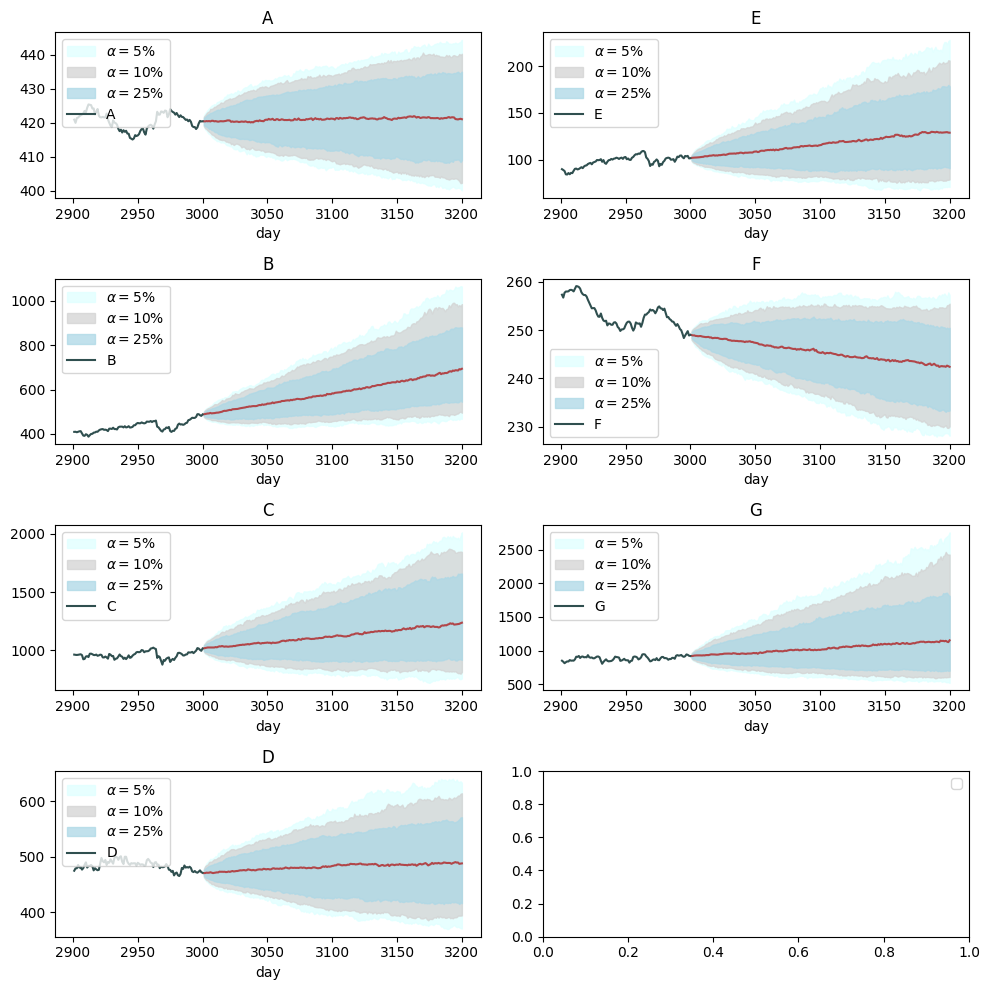

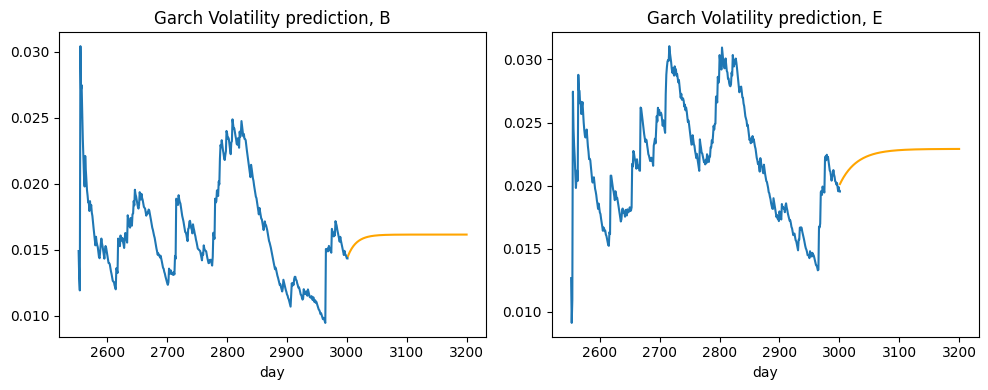

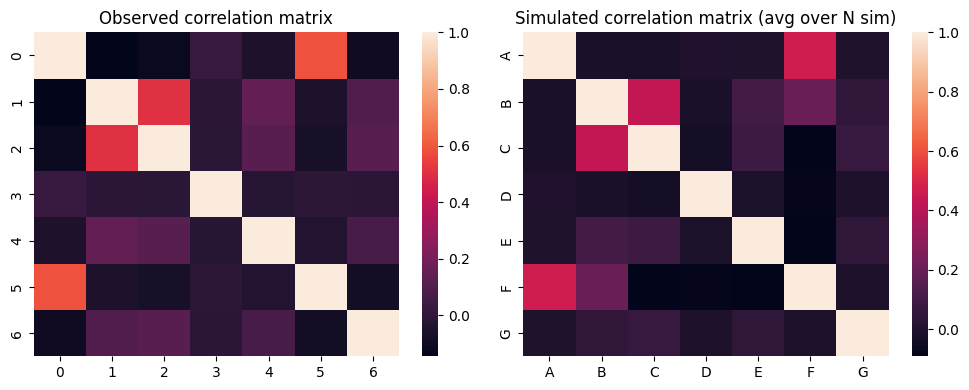

In [51]:
class Correlation(object):
    def __init__(self, X):
        self.X = X

    def SampleCorrelation(self):
        return np.array(self.X.corr())

    def TestCorrelation(self, rho=0.95):
        # create toy correlation matrix to sense check results
        R = self.X.corr()
        M = np.zeros(np.shape(R))
        M[0][1] = rho
        M[1][0] = rho
        I = np.identity(np.shape(R)[0])
        R = I + M
        return R

    def __call__(self, name):
        return getattr(self, name)()
        
class PriceExtrapolationSimulation(object):

    def __init__(self, settings):
        for key, val in settings.items():
            setattr(self, key, val)

    def _load(self):
        data = pd.read_csv("data.csv", index_col=0)
        self.log_r = np.log(data / data.shift(1))
        self.data = data

    def _estimate_mu(self, t0, t1):
        self.mu = self.log_r.ewm(halflife=(t1 - t0) / 2).mean().loc[t0 - 1]

    def _ewm_vol(self, t0, t1):
        sigma = self.log_r.ewm(halflife=(t1 - t0) / 2).std().loc[t0 - 1]
        self.sigma = pd.DataFrame({t: sigma for t in self.data.index[t0 - 1:t1]}).T

    def _garch_vol_asset(self, t0, t1, ticker, k=1000, n_train=600, p=1, q=1):
        n_steps = (t1 - t0 + 1)  # step ahead forecast
        model = arch_model(k * self.log_r.dropna().loc[t0 - n_train:t0, ticker], vol='Garch', p=p,
                           q=q)  # k is scaling factor used for numerical stability
        garch_fit = model.fit(disp="off")
        garch_forecast = garch_fit.forecast(horizon=n_steps)
        vol_pred = pd.Series(1 / k * np.sqrt(garch_forecast.variance.values[-1, :]), index=self.data.loc[t0:t1].index)

        return vol_pred

    def _garch_vol(self, t0, t1):
        sigma_pred = {ticker: self._garch_vol_asset(t0, t1, ticker) for ticker in self.data.columns}
        self.sigma = pd.DataFrame(sigma_pred)

    def _estimate_sigma(self, t0, t1):
        # or could be a GARCH prediction
        if self.vol_model == "EWMVol":
            self._ewm_vol(t0, t1)
        elif self.vol_model == "GARCH":
            self._garch_vol(t0, t1)
        else:
            raise Exception(f"{self.vol_model} is not supported")

    def _sim_corr_returns(self, t0, t1):
        N = (t1 - t0 + 1)
        
        # generate uncorrelated random variables with volatility obtained as per desired vol estimate 
        X_uncorr = np.column_stack([np.array([np.random.normal(0, sigma) for sigma in self.sigma[ticker]]) for ticker in self.sigma.columns])
        # X_uncorr = np.column_stack([np.random.normal(0, sigma, N) for sigma in self.sigma])
        R = Correlation(X=self.log_r)(self.correlation)
        L = np.linalg.cholesky(R)  # Cholesky decomposition
        Y = X_uncorr @ L.T

        Y = self.mu + pd.DataFrame(Y, columns=self.log_r.columns, index=self.log_r.loc[t0:t1].index)
        S = self.data.loc[t0 - 1] * np.exp(Y.cumsum())
        self.R = R
        return S

    def _generate_trajectories(self, t0, t1):
        self.prices = {n: self._sim_corr_returns(t0, t1) for n in range(self.n_sim)}

    def _get_quantiles_ticker(self, ticker, alphas):

        traj = pd.concat([self.prices[n][ticker] for n in self.prices], axis=1)
        quantile_ts = {}
        for alpha in alphas:
            quantile_ts[alpha] = {
                "median": traj.median(axis=1),
                "upper": traj.quantile(alpha / 2, axis=1),
                "lower": traj.quantile(1 - alpha / 2, axis=1)}

        return quantile_ts

    def _get_quantiles(self, alphas):
        self.quantiles = {ticker: self._get_quantiles_ticker(ticker, alphas) for ticker in self.data.columns}

    def _plot(self, t0, t1, alphas):
    
        i, j = 0, 0
        fig, axes = plt.subplots(4, 2, figsize=(10, 10))
    
        for ticker in self.quantiles:
            d = self.quantiles.get(ticker)
    
            ax = axes[i, j]
            for alpha in alphas:
                ts = d[alpha]
                ax.fill_between(x=ts.get("upper").index, y1=ts.get("median"), y2=ts.get("upper"), alpha=0.75,
                                color=alphas[alpha], label=r"$\alpha=$" + f"{int(alpha * 100)}%")
                ax.fill_between(x=ts.get("lower").index, y1=ts.get("median"), y2=ts.get("lower"), alpha=0.75,
                                color=alphas[alpha])
    
            ax.plot(ts.get("median"), color="firebrick", alpha=0.8)
            self.data.loc[t0 - 100:, ticker].plot(color="darkslategrey", ax=ax)
            ax.legend()
            ax.set_title(f"{ticker}")
            i += 1
            if i % 4 == 0:
                i = 0
                j += 1
            if j % 2 == 0:
                j = 0
    
        plt.legend()
        plt.tight_layout()

        if self.vol_model == "GARCH":
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            ticker = "B"
            self.sigma[ticker].plot(ax=axes[0], color="orange")
            log_r.loc[t0-450:t0, ticker].ewm(halflife=20).std().plot(ax=axes[0])
            axes[0].set_title(f"Garch Volatility prediction, {ticker}")
            
            ticker = "E"
            self.sigma[ticker].plot(ax=axes[1], color="orange")
            log_r.loc[t0-450:t0, ticker].ewm(halflife=20).std().plot(ax=axes[1])
            axes[1].set_title(f"Garch Volatility prediction, {ticker}")
            plt.tight_layout()
        
    def _plot_corr_matrix(self):
        R_sim = sum([np.log(p / p.shift(1)).corr() for p in self.prices.values()]) / self.n_sim
        R_obs = self.R
    
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
        sns.heatmap(R_obs, ax=axes[0])
        axes[0].set_title("Observed correlation matrix")
        sns.heatmap(R_sim, ax=axes[1])
        axes[1].set_title("Simulated correlation matrix (avg over N sim)")
    
        plt.tight_layout()

    def __call__(self, t0, t1, alphas, plot=True):

        self._load()
        self._estimate_mu(t0, t1)
        self._estimate_sigma(t0, t1)
        self._generate_trajectories(t0, t1)
        self._get_quantiles(alphas)
        if plot:
            self._plot(t0, t1, alphas)
            self._plot_corr_matrix()

# vol_model = "EWMVol, GARCH"
PriceExtrapolationSimulation(dict(n_sim=500, vol_model="GARCH", correlation="SampleCorrelation",))(t0=3001, t1=3200, alphas=alphas)

Sense-checking the results by constraining the correlation matrix $R$ such that: 
* $\rho(A,B)=0.95$
* $\rho(i,j)=0$  $(i,j) \neq (A,B)$

The correlation structure constrains the behaviour of asset B, resulting in a narrower confidence interval

C:\Users\Romain\AppData\Local\Temp\ipykernel_20904\1246412653.py:122: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


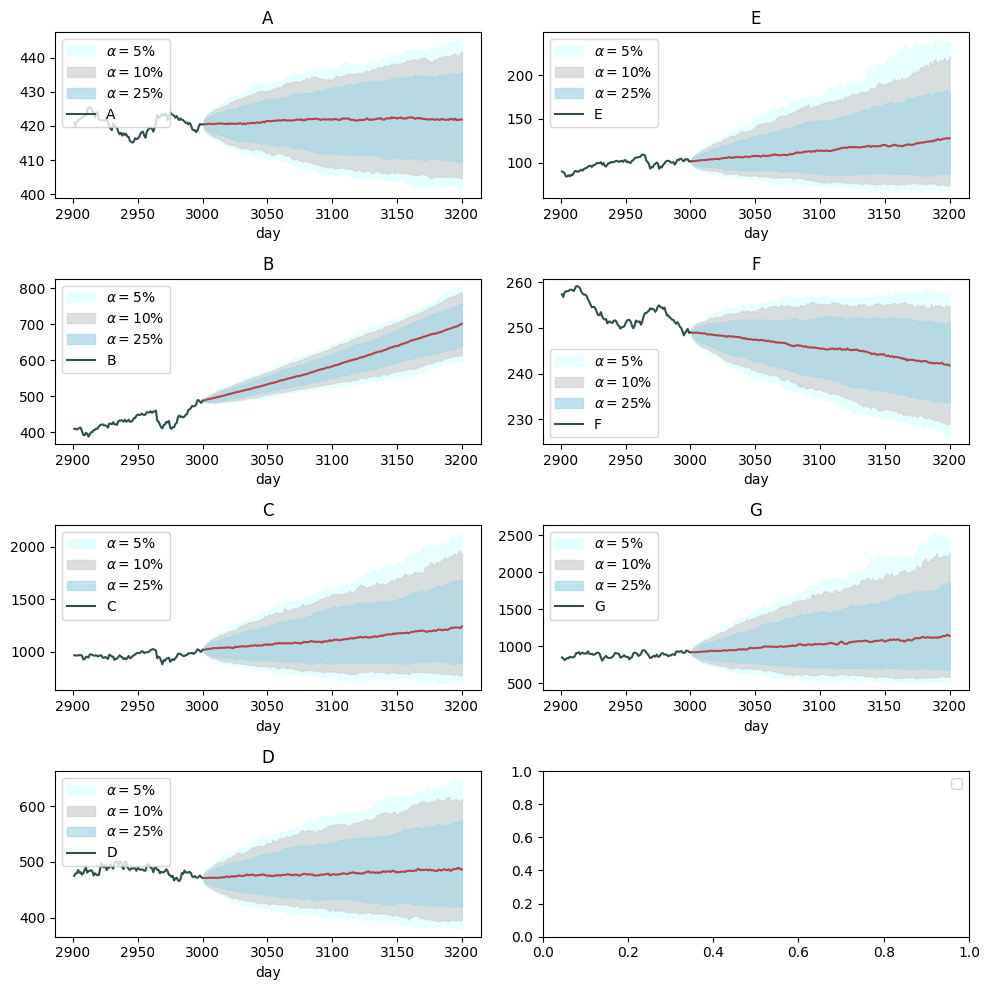

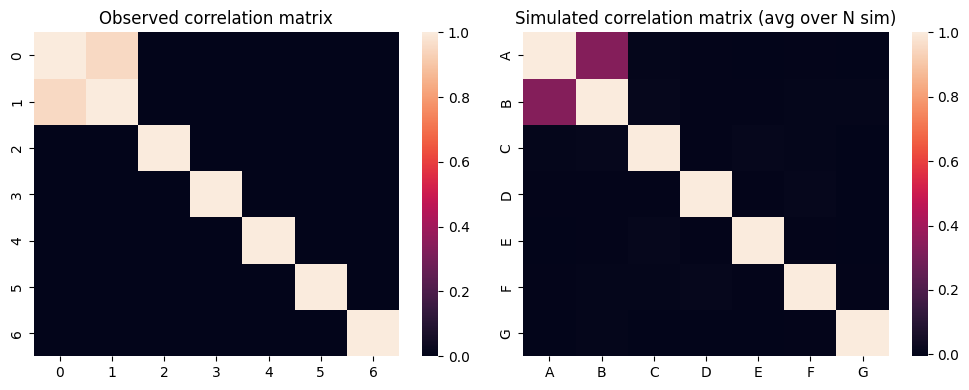

In [42]:
PriceExtrapolationSimulation(dict(n_sim=500, vol_model="GARCH", correlation="TestCorrelation",))(t0=3001, t1=3200, alphas=alphas)